In [56]:
from rasterio.features import rasterize
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt

# Paths files
tif_POST = 'Data/GLCM POST.tif'
tif_PRE = 'Data/GLCM PRE.tif'

scratch_dir = './scratch' 

def print_band_info(tif_file):
    with rasterio.open(tif_file) as src:
        print(f"Information for: {tif_file}")
        print(f"Number of bands: {src.count}")
        for i in range(1, src.count + 1):
            band = src.read(i)
            print(f"Band {i} shape: {band.shape}")
        print("-" * 40)

# Print available bands
print_band_info(tif_PRE)
print_band_info(tif_POST)

Information for: Data/GLCM PRE.tif
Number of bands: 10
Band 1 shape: (392, 537)
Band 2 shape: (392, 537)
Band 3 shape: (392, 537)
Band 4 shape: (392, 537)
Band 5 shape: (392, 537)
Band 6 shape: (392, 537)
Band 7 shape: (392, 537)
Band 8 shape: (392, 537)
Band 9 shape: (392, 537)
Band 10 shape: (392, 537)
----------------------------------------
Information for: Data/GLCM POST.tif
Number of bands: 10
Band 1 shape: (392, 537)
Band 2 shape: (392, 537)
Band 3 shape: (392, 537)
Band 4 shape: (392, 537)
Band 5 shape: (392, 537)
Band 6 shape: (392, 537)
Band 7 shape: (392, 537)
Band 8 shape: (392, 537)
Band 9 shape: (392, 537)
Band 10 shape: (392, 537)
----------------------------------------


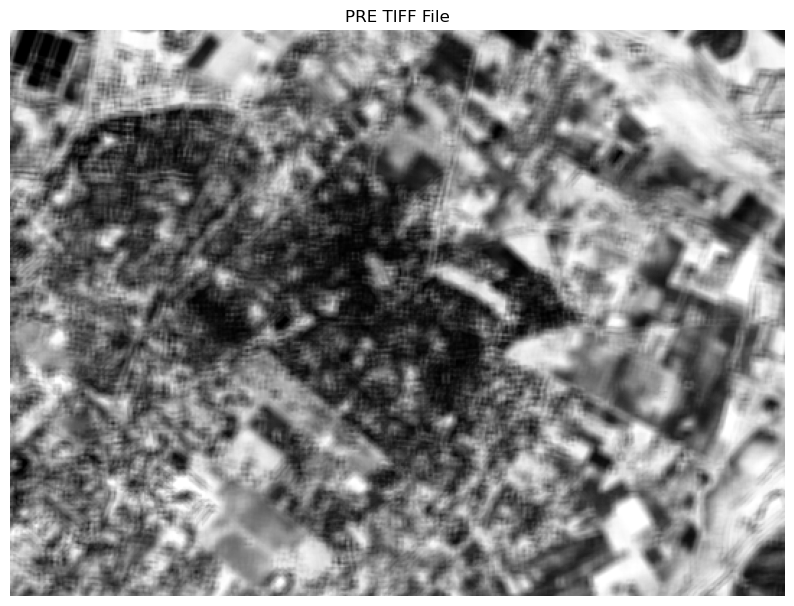

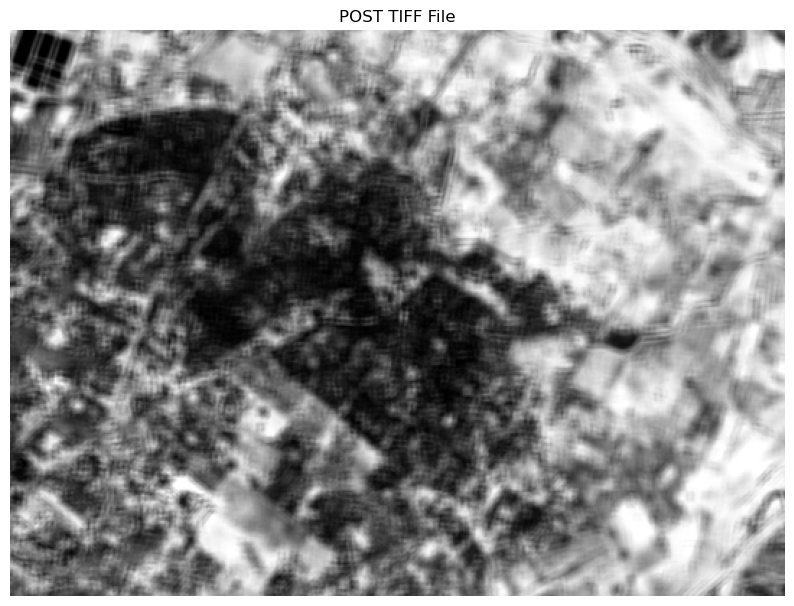

In [57]:
def display_band(tif_file, title, band_number):
    with rasterio.open(tif_file) as src:
        # Check if the file has at least x bands
        if src.count < band_number:
            print(f"File {tif_file} does not have 8 bands.")
            return

        band = src.read(band_number)

        plt.figure(figsize=(10, 10))
        plt.imshow(band, cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

display_band(tif_PRE, "PRE TIFF File", 8)
display_band(tif_POST, "POST TIFF File", 8)

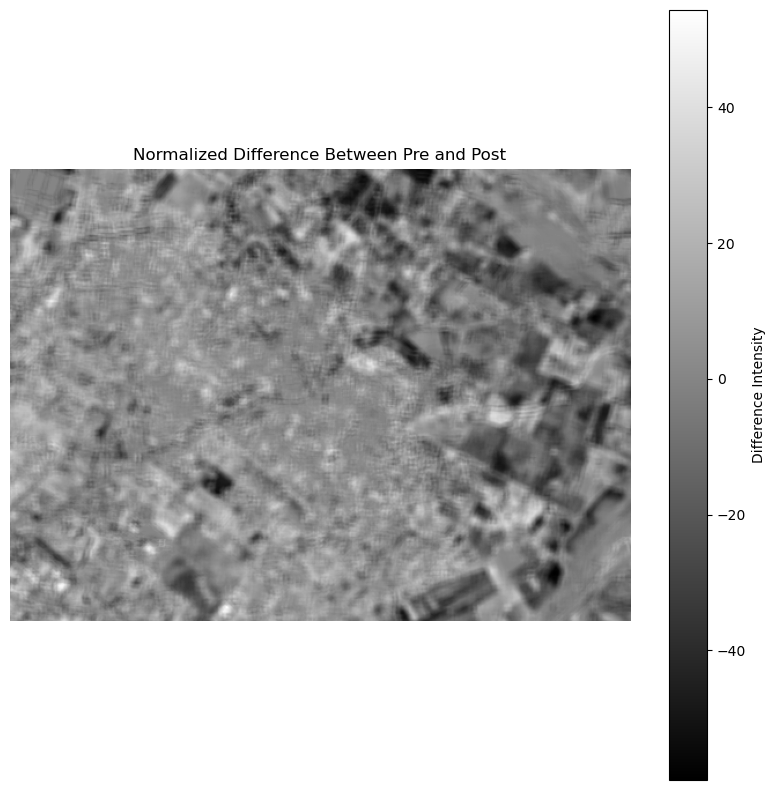

Image saved to: ./scratch/Normalized_difference.tif


In [58]:
def read_band(tif_file, band_nr):
    with rasterio.open(tif_file) as src:
        # Check if the file has at least 8 bands
        if src.count < band_nr:
            print(f"File {tif_file} does not have 8 bands.")
            return None
        # Read the 8th band
        band = src.read(band_nr)
        return band

# Read the 8th band from both files
band_Pre = read_band(tif_PRE, 8)
band_Post = read_band(tif_POST, 8)

if band_Pre is not None and band_Post is not None:
    # Check if the bands have the same shape
    if band_Pre.shape != band_Post.shape:
        print("The bands of the two files do not have the same shape.")
    else:
        # Compute the difference
        difference = band_Pre - band_Post

        # Display the difference image
        plt.figure(figsize=(10, 10))
        plt.imshow(difference, cmap='gray')
        plt.title("Normalized Difference Between Pre and Post")
        plt.axis('off')  # Hide the axes
        plt.colorbar(label='Difference Intensity')
        plt.show()

        # Use the metadata of the first file as a template for the output file
        with rasterio.open(tif_PRE) as src:
            meta = src.meta
        meta.update(count=1)

        output_tif = f"Normalized_difference.tif"
        output_tif = os.path.join(scratch_dir, output_tif)

        # Write the difference image to a new TIFF file
        with rasterio.open(output_tif, 'w', **meta) as dst:
            dst.write(difference, 1)

        print(f"Image saved to: {output_tif}")

In [59]:
import rasterio
import numpy as np
from skimage.feature import graycomatrix, graycoprops

# Read GLCM difference TIFF
with rasterio.open('Scratch/Normalized_difference.tif') as src:
    glcm_difference = src.read(1)

# Ensure the GLCM difference values are integers
glcm_difference = glcm_difference.astype(np.uint8)

# Define the distance and angle offsets for GLCM calculation
distances = [1]  # Distance between pixels
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles for co-occurrence

# Calculate GLCM
glcm = graycomatrix(glcm_difference, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

# Extracting texture features
contrast = graycoprops(glcm, 'contrast')
dissimilarity = graycoprops(glcm, 'dissimilarity')
homogeneity = graycoprops(glcm, 'homogeneity')
energy = graycoprops(glcm, 'energy')
correlation = graycoprops(glcm, 'correlation')

# Calculating Entropy
entropy = -np.sum(glcm * np.log2(glcm + 1e-10), axis=(2, 3)) 

# Printing the results
print("GLCM Matrix:")
# print(glcm)

print("\nTexture Features:")
print(f"Contrast: {contrast}")
print(f"Dissimilarity: {dissimilarity}")
print(f"Homogeneity: {homogeneity}")
print(f"Energy (ASM): {energy}")
print(f"Correlation: {correlation}")
print(f"Entropy: {entropy}")


GLCM Matrix:

Texture Features:
Contrast: [[4261.14700731 6053.04333511 4661.97740597 6044.89101328]]
Dissimilarity: [[18.64368527 26.45704661 20.32154577 26.37926576]]
Homogeneity: [[0.38120366 0.29813939 0.36713999 0.3040101 ]]
Energy (ASM): [[0.06257054 0.0529629  0.06045025 0.05327923]]
Correlation: [[0.84483189 0.77957597 0.83024743 0.77987259]]
Entropy: [[0.57564308 0.26691014 0.18929937 ... 0.1142776  0.15868438 0.24144943]
 [0.26691014 0.22297289 0.18445447 ... 0.03921292 0.06027423 0.08885551]
 [0.18929937 0.18445447 0.19051003 ... 0.02693913 0.04209108 0.06113306]
 ...
 [0.1142776  0.03921292 0.02693913 ... 0.14329131 0.12830947 0.10222535]
 [0.15868438 0.06027423 0.04209108 ... 0.12830947 0.15976666 0.14353417]
 [0.24144943 0.08885551 0.06113306 ... 0.10222535 0.14353417 0.1880975 ]]


The texture features extracted from the Gray Level Co-occurrence Matrix (GLCM) provide valuable information about the spatial distribution of pixel intensities (gray levels) in an image, characterizing its texture. Each feature captures a different aspect of texture:

1. **Contrast**: This measures the intensity contrast between a pixel and its neighbor over the whole image. High contrast values indicate a large difference in intensities and suggest the presence of strong edges or textures in the image. Low contrast suggests a smoother, more uniform appearance.

2. **Dissimilarity**: Similar to contrast, dissimilarity measures the difference in intensities between a pixel and its neighbor, but it gives more weight to pairs that are more dissimilar. Like contrast, higher values indicate stronger textures, but this measure is more sensitive to finer textural variations.

3. **Homogeneity**: This quantifies the closeness of the distribution of elements in the GLCM to the GLCM diagonal. It reaches high values when the intensity values of pixel pairs are similar or when the image texture is very fine. A high homogeneity value indicates a more homogeneous or less textured image.

4. **Energy (or Angular Second Moment - ASM)**: Energy provides a measure of textural uniformity. High energy values occur when pixel intensity distributions are either constant or periodic. High energy implies that the image texture is very regular and repetitive, whereas low energy indicates a more complex or less repetitive texture.

5. **Correlation**: This feature measures the linear dependency of gray level values in the GLCM. High correlation values indicate a linear or predictable relationship between the gray levels of pixel pairs, suggesting a structured, possibly textured pattern in the image. Low correlation values indicate a less structured or more random distribution of intensities.

6. **Entropy**: Entropy measures the randomness in the gray level distribution. High entropy values suggest a high degree of disorder or complexity in the image texture, indicating a rich variety of textures or patterns. Low entropy values suggest a more uniform or less complex texture.

By analyzing these texture features, one can infer various properties about the image's texture:

- **Smooth vs. Rough Texture**: Low contrast, high homogeneity, and low entropy usually indicate a smooth texture. In contrast, high contrast, low homogeneity, and high entropy suggest a rough texture.
- **Regular vs. Irregular Texture**: High energy (ASM) and correlation indicate a regular, predictable texture pattern, while low values suggest an irregular, less predictable texture.
- **Complexity**: High dissimilarity and entropy values can indicate a more complex texture with a wide variety of patterns or elements.

These texture features are particularly useful in fields like medical imaging (identifying different tissues or conditions), remote sensing (classifying land use or vegetation types), materials science (characterizing surface properties), and any application where the texture provides meaningful insights.

Using GLCM (Gray Level Co-occurrence Matrix) texture features to classify polygons in a shapefile as "destroyed" or "not destroyed" involves several steps. These steps include extracting texture features from the image regions corresponding to the polygons, analyzing these features to find a meaningful threshold, and then applying a classification model. Here’s a general approach to achieve this:

### 1. Preprocessing:
- **Rasterize Polygons**: Convert the polygons from the shapefile into a raster format where each pixel within a polygon is assigned a unique identifier. This is important because the GLCM texture features will be calculated for the image areas corresponding to these polygons.

### 2. Feature Extraction:
- **Extract GLCM Features for Each Polygon**: For each polygon (now rasterized), calculate the GLCM and subsequently extract texture features (contrast, dissimilarity, homogeneity, energy, correlation, entropy) from the image areas corresponding to the polygons. This involves creating a mask for each polygon to isolate its area in the image and then calculating the GLCM features for these specific areas.

### 3. Analysis and Model Training:
- **Feature Analysis**: Analyze the extracted GLCM features to understand how they correlate with the "destroyed" or "not destroyed" classes. This might involve statistical analysis or visualization (like plotting feature distributions for each class) to identify which features (or combinations thereof) best discriminate between the two classes.
- **Select Features and Find Threshold**: Based on the analysis, select the most relevant features that differentiate between the two classes. Then, you can use these features to find an optimal threshold or set of thresholds that best classify the polygons. This can be done through various methods, such as manually inspecting feature distributions, using algorithms like Otsu's method (if applicable), or applying machine learning models.
- **Train a Classification Model**: If the relationship between features and classes is complex, consider training a machine learning model (e.g., Decision Trees, Random Forest, SVM) using the selected features as inputs and the "destroyed"/"not destroyed" labels as outputs. This model will inherently find the "best threshold" in a multidimensional feature space to classify the polygons.

### 4. Classification and Validation:
- **Classify Polygons**: Use the chosen threshold or trained model to classify each polygon based on its GLCM features.
- **Validation**: It’s crucial to validate the classification results against known data to assess the accuracy of your threshold or model. This could involve cross-validation techniques or splitting your data into training and testing sets.

### Implementation Considerations:
- The resolution of your imagery and the size of your polygons might affect the reliability of the GLCM features. Ensure that the polygons are sufficiently large relative to the image resolution to extract meaningful texture information.
- The choice of GLCM parameters (distance, angle) and the selection of texture features should be based on the specific characteristics of your data and the nature of the "destruction" you're trying to detect.
- If using machine learning, feature scaling might be necessary to ensure that all features contribute equally to the model.

This approach involves a mix of GIS operations (for handling shapefiles and raster data), image processing (for GLCM calculation and feature extraction), and machine learning/data analysis (for feature selection, threshold finding, and classification). Tools and libraries like GDAL, Rasterio (for raster data handling), scikit-image (for GLCM and texture analysis), and scikit-learn (for machine learning and data analysis) can be instrumental in this process.

In [60]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from skimage.feature import graycomatrix, graycoprops
import numpy as np

def rasterize_shapefile(shapefile, affine, shape):
    shapes = ((geom, value) for geom, value in zip(shapefile.geometry, shapefile.index))
    rasterized = rasterize(shapes=shapes, out_shape=shape, transform=affine, fill=-1, all_touched=True, dtype=rasterio.int16)
    return rasterized

# Load the shapefile
shapefile = gpd.read_file('/Volumes/SSD PERDECK/DamagedNoBufferBinair.shp')
# shapefile = gpd.read_file('/Volumes/SSD PERDECK/DamagedWithBufferBinair.shp')

# Load the corresponding image to get the affine transform and dimensions
with rasterio.open('Scratch/Normalized_difference.tif') as src:
    affine = src.transform
    shape = src.shape
    image_data = src.read(1)  # Reading the first band as an example

# Rasterize the shapefile
rasterized_shapefile = rasterize_shapefile(shapefile, affine, shape)

# Initialize a dictionary to hold the ROI data
texture_features = {}

# Define GLCM parameters
distances = [1]  # Example: Pixel pair distance of 1
angles = [0]  # Example: Horizontal pixel pairs

# Iterate through each unique identifier in the rasterized shapefile
for uid in np.unique(rasterized_shapefile):
    if uid == -1:  # Skip the fill value
        continue
    mask = rasterized_shapefile == uid
    
    # Create a masked 2D array where non-ROI pixels are set to 0
    masked_image = np.where(mask, image_data, 0)
    
    # Check if the masked area is empty or contains only zeros
    if np.count_nonzero(masked_image) == 0 or masked_image.max() == 0:
        continue  # Skip if the masked area is empty or max value is 0
    
    # Convert data to uint8 and handle divide by zero
    masked_image_scaled = np.nan_to_num(masked_image / masked_image.max() * 255)
    masked_image_uint8 = masked_image_scaled.astype(np.uint8)

    # Calculate GLCM on the masked 2D ROI
    glcm = graycomatrix(masked_image_uint8, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    # Extract and store all GLCM features for each ROI
    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
        'ASM': graycoprops(glcm, 'ASM')[0, 0],  # Angular Second Moment
    }
    
    # Feature Engineering: Creating new features
    features['contrast_homogeneity_ratio'] = features['contrast'] / (features['homogeneity'] + 1e-5)  # Avoid division by zero
    features['energy_correlation_ratio'] = features['energy'] / (features['correlation'] + 1e-5)
    features['contrast_dissimilarity_sum'] = features['contrast'] + features['dissimilarity']
    
    # You can continue adding more custom features based on domain knowledge or experimentation
    
    texture_features[uid] = features


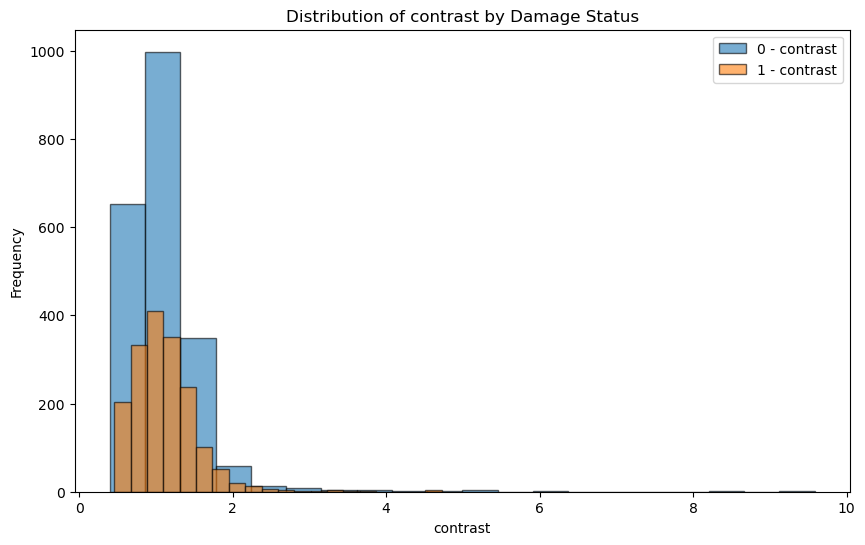

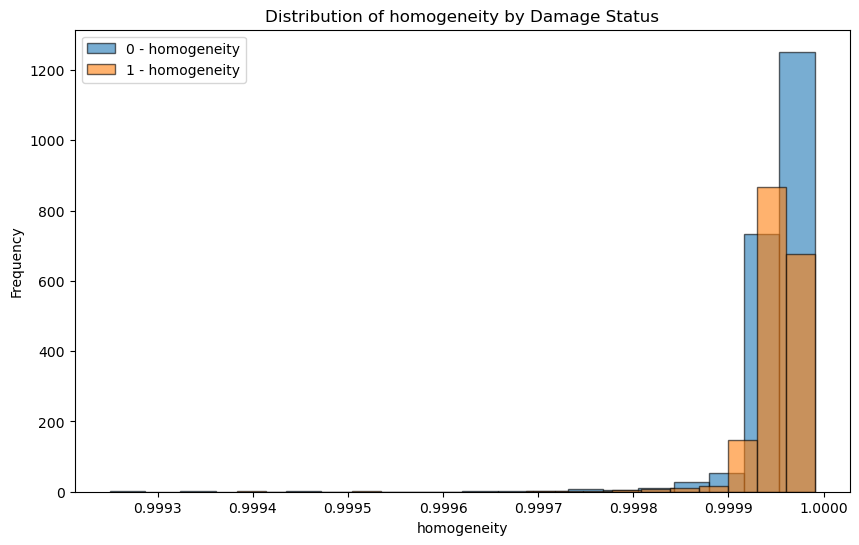

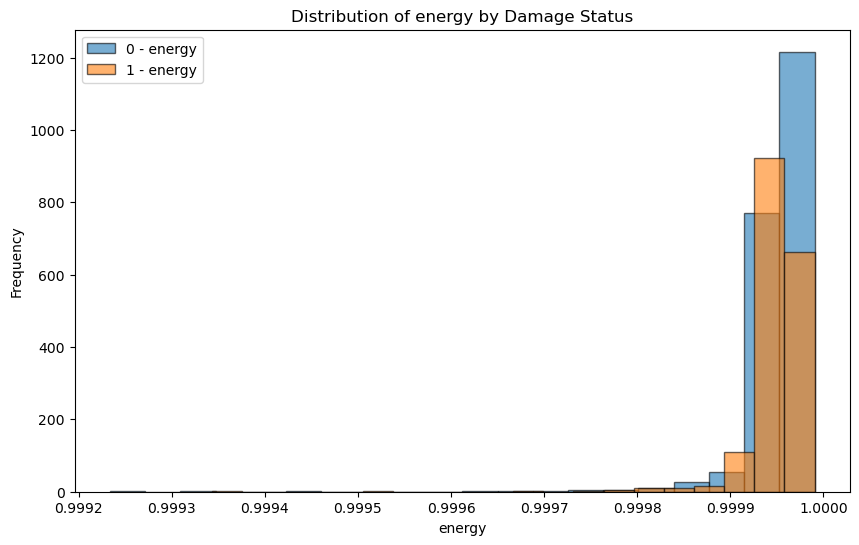

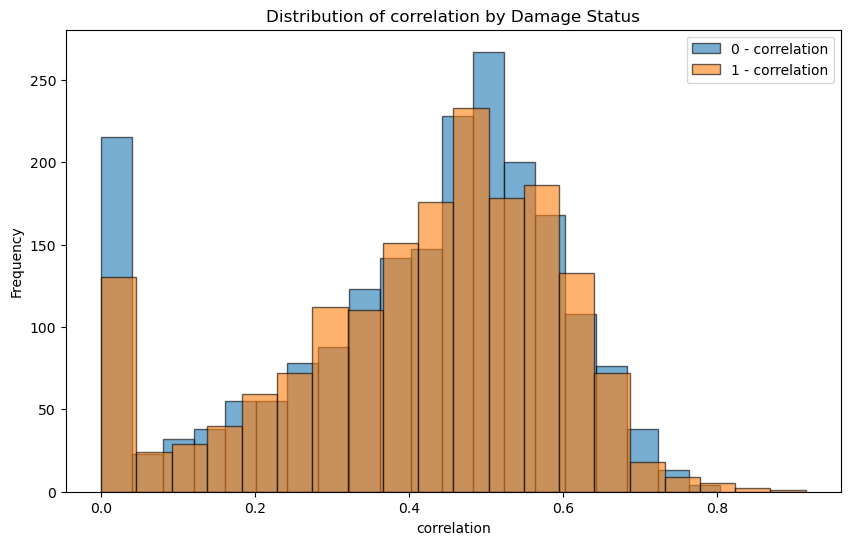

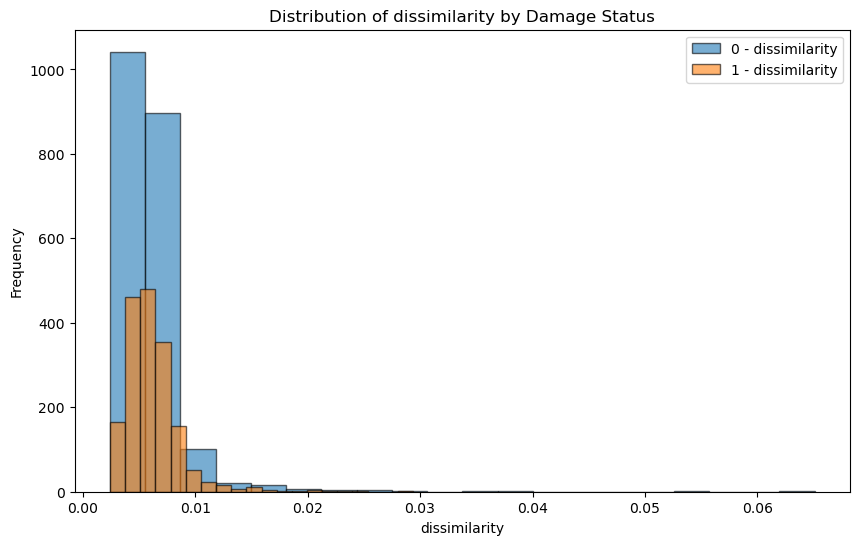

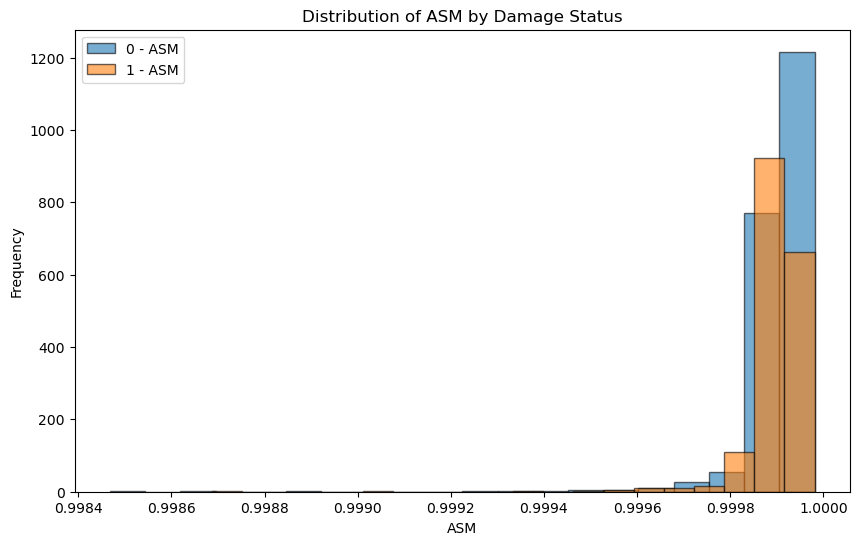

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming texture_features is a dictionary where keys are indices (matching shapefile index) and values are feature dicts
df_features = pd.DataFrame.from_dict(texture_features, orient='index')
#print(df_features)

# Add the 'damage' status from the shapefile to the feature DataFrame
df_features['damaged'] = shapefile.loc[df_features.index, 'damaged'].values

# Visualizing the distribution of multiple features for both classes
features_to_plot = ['contrast', 'homogeneity', 'energy', 'correlation', 'dissimilarity', 'ASM']

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    for status in df_features['damaged'].unique():
        subset = df_features[df_features['damaged'] == status]
        plt.hist(subset[feature], label=f"{status} - {feature}", alpha=0.6, bins=20, edgecolor='black')
    plt.title(f'Distribution of {feature} by Damage Status')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Prepare the data
X = df_features[['contrast', 'homogeneity', 'energy', 'correlation', 'dissimilarity', 'ASM']].values
y = LabelEncoder().fit_transform(df_features['damaged'].values) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluate the model's performance
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 0.52734375
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       416
           1       0.48      0.42      0.45       352

    accuracy                           0.53       768
   macro avg       0.52      0.52      0.52       768
weighted avg       0.52      0.53      0.52       768


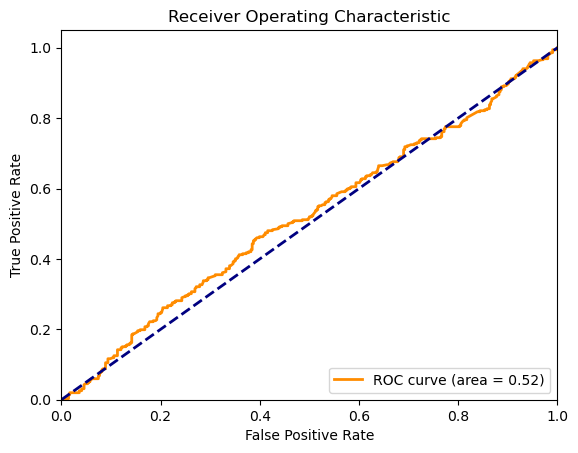

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a binary classifier 'clf' and test data 'X_test', 'y_test'
y_scores = clf.predict_proba(X_test)[:, 1]  # Get the scores for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2],  # Minimum number of samples required at each leaf node
}

# Initialize GridSearchCV with RandomForestClassifier and the parameter grid
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score achieved during GridSearch
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Retrieve the best estimator (model) from GridSearchCV
best_clf = grid_search.best_estimator_

# Use the best model to make predictions on the test set
y_pred = best_clf.predict(X_test)

# Evaluate the best model's performance on the test set
print(f'Accuracy of the best model: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.5498371335504886
Accuracy of the best model: 0.5520833333333334
              precision    recall  f1-score   support

           0       0.57      0.72      0.63       416
           1       0.52      0.36      0.42       352

    accuracy                           0.55       768
   macro avg       0.54      0.54      0.53       768
weighted avg       0.54      0.55      0.54       768


Optimal Threshold: 1.1407249466950962


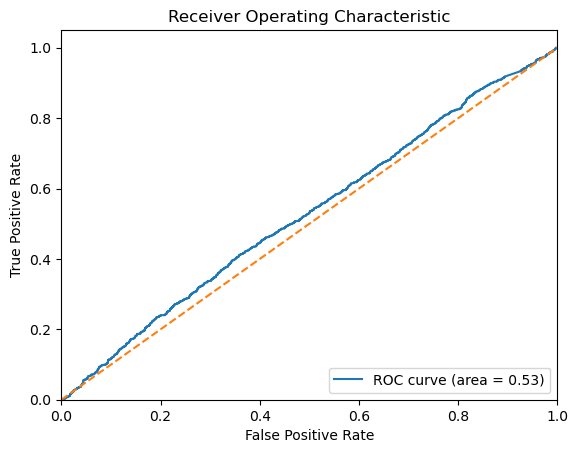

In [65]:
from sklearn.metrics import roc_curve, auc

# Assuming you use 'contrast' as the score for ROC analysis
# Make sure to replace 'contrast' with the actual feature you want to use
fpr, tpr, thresholds = roc_curve(df_features['damaged'], df_features['contrast'])
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Display the optimal threshold and plot the ROC curve
print("Optimal Threshold:", optimal_threshold)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
